In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit

### Cumulative Advantage

For each (filtered) cohort analyze how the distribution of citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero citations). Over time some scientists become more successful than others which leads to an increase in the Gini coefficient.

In [3]:
start_time = timeit.default_timer()
print(start_time)

1.973763161052758e-06


In [6]:
#authorStartEndCareerData = pd.read_csv('data/authors-scientific-start-end-year-publish-count.csv')
authorStartEndCareerData = pd.read_csv('data/authors-scientific-atleast-15-year.csv')
#authorStartEndCareerData = pd.read_csv('data/authors-scientific-atleast-20-year.csv')

authorStartEndCareerData.head()



             author  start_year  end_year  pub_count  career_length
3  a. a. abouelsoud        1996      2016         10             20


In [5]:
#What happens with people for which we do not observe a publication in one year. 

groupByStartYearScientificCareerData = authorStartEndCareerData[['author','start_year']].groupby(['start_year'])
#groupByStartYearScientificCareerData.groups

{1991: [4,
  18,
  27,
  33,
  38,
  40,
  46,
  52,
  72,
  86,
  97,
  100,
  106,
  116,
  121,
  125,
  130,
  142,
  145,
  163,
  196,
  211,
  213,
  221,
  234,
  247,
  251,
  262,
  277,
  295,
  340,
  342,
  343,
  357,
  397,
  402,
  421,
  440,
  442,
  457,
  461,
  465,
  470,
  473,
  479,
  493,
  500,
  518,
  520,
  557,
  561,
  572,
  573,
  582,
  590,
  630,
  632,
  692,
  756,
  778,
  791,
  792,
  796,
  797,
  807,
  808,
  842,
  868,
  884,
  893,
  940,
  951,
  971,
  973,
  1001,
  1004,
  1020,
  1029,
  1038,
  1041,
  1043,
  1056,
  1058,
  1083,
  1095,
  1107,
  1109,
  1116,
  1117,
  1123,
  1141,
  1168,
  1170,
  1189,
  1203,
  1241,
  1253,
  1261,
  1278,
  1288,
  1302,
  1307,
  1317,
  1324,
  1325,
  1334,
  1336,
  1339,
  1345,
  1350,
  1357,
  1365,
  1366,
  1384,
  1385,
  1394,
  1421,
  1423,
  1424,
  1436,
  1450,
  1458,
  1476,
  1482,
  1491,
  1499,
  1581,
  1595,
  1612,
  1625,
  1693,
  1698,
  1713,
  1720,
  1740,


In [5]:
authorCitationsData = pd.read_csv('data/authors_cite_2016_asiansAsNone.txt')

# we have to create a smaller subset - for now - ignore the comments below
# To speed up the implementation, if required consider a small dataset
# Look at 'shorten-dblp-data-for-faster-access' notebook to creat a smaller dataset
#authorPublicationsData = pd.read_csv('data/author_publications_1970_2000_asiansAsNone.csv')
authorCitationsData.head()

#id1 represents the author who cited
#id2 is the author who has been cited by id1

,id1,id2,year
0,stefano rizzi,qiong fang,2006
1,stefano rizzi,jianlin feng,2006
2,stefano rizzi,hulin ding,2006
3,alberto abelló,qiong fang,2006
4,alberto abelló,jianlin feng,2006


In [6]:
#get the year list - 1970 to 2016
years = np.arange(1970,2017)
years

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016])

In [7]:
#Group by both year and author(id2 here) - multi index and hierarchial indexing
groupByAuthorYear = authorCitationsData.groupby(['year','id2'])
# count of no. of publications for each and every author for every year
groupByAuthorYearData = groupByAuthorYear.count() 

# id1 - represents the no. of authors who cited

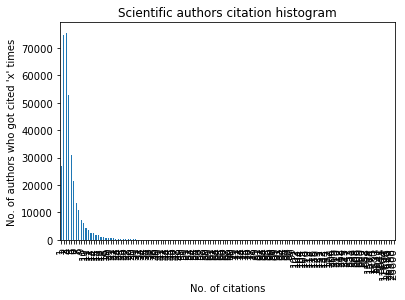

count      135.000000
mean      2566.051852
std      10852.940838
min          1.000000
25%          2.000000
50%          7.000000
75%        100.000000
max      75503.000000
Name: id1, dtype: float64

In [8]:
scientificYearStartHistogram = groupByAuthorYearData['id1'].value_counts(sort=False)
ax = scientificYearStartHistogram.sort_index().plot(kind='bar', title='Scientific authors citation histogram')
ax.set_xlabel("No. of citations")
ax.set_ylabel("No. of authors who got cited 'x' times")
plt.show()

scientificYearStartHistogram.describe()

In [9]:
#the following snippet is taken from the github project and the license is creative commons
#https://github.com/oliviaguest/gini

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.min(array) < 0:
        # Values cannot be negative:
        array -= np.min(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [10]:
gini_evolution = pd.DataFrame(index=years)
non_publishers_track = pd.DataFrame(index=years)
for year in groupByStartYearScientificCareerData.indices:
    authors_for_comparison = groupByStartYearScientificCareerData.get_group(year)
    gini_over_years = pd.Series(data=0, index=years)
    non_publishers_over_years = pd.Series(data=0, index=years)
    for i in range(year, max(years)+1):
        # get all the authors data for each year and filter based on the authors that we are interested in
        if i in groupByAuthorYearData.index:
            temp = groupByAuthorYearData.loc[i] 
            check = temp.index.isin(authors_for_comparison['author'])
            if check.sum() > 0: 
                temp = temp.loc[authors_for_comparison['author']]
                noOfAuthorsWhoPublishedNothing = temp.isnull().sum()['id1'] / temp.size

                # fill 0 for authors who has not published and change the data to float for gini function (relevant to implementaion) to work
                temp.fillna(value=0, inplace=True)
                #temp = temp['pub_id'].values
                #groupByAuthorYearData.loc[i]['pub_id'].as_matrix()
                temp = temp.astype(float)
                gini_over_years.loc[i] = gini(temp['id1'].values)
                non_publishers_over_years.loc[i] = noOfAuthorsWhoPublishedNothing
            else :
                gini_over_years.loc[i] = 0
                non_publishers_over_years.loc[i] = 0
        #break
    #break
        #else:
        #    print(year,i)
         
    gini_evolution[year] = gini_over_years
    non_publishers_track[year] = non_publishers_over_years
    #print(year)
    #print(gini_evolution[year])
        

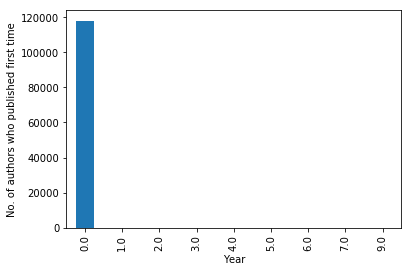

count         9.000000
mean      13111.111111
std       39326.958360
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max      117983.000000
Name: id1, dtype: float64

In [11]:
#authors_for_comparison.describe()

scientificYearStartHistogram = temp['id1'].value_counts(sort=False)
ax = scientificYearStartHistogram.sort_index().plot(kind='bar')
ax.set_xlabel("Year")
ax.set_ylabel("No. of authors who published first time")
plt.show()

scientificYearStartHistogram.describe()

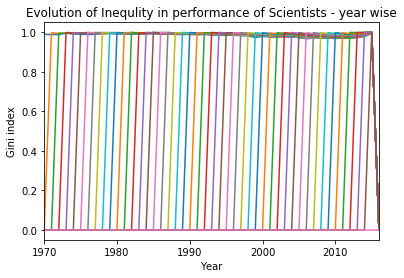

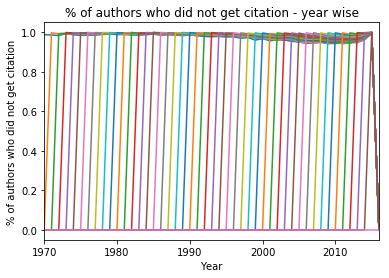

In [12]:
ax = gini_evolution.plot(title='Evolution of Inequlity in performance of Scientists - year wise', 
                         legend=False)
ax.set_xlabel("Year")
ax.set_ylabel("Gini index")
plt.show()


ax = non_publishers_track.plot(title='% of authors who did not get citation - year wise',
                              legend=False)
ax.set_xlabel("Year")
ax.set_ylabel("% of authors who did not get citation")
plt.show()

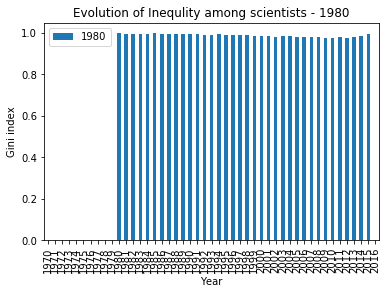

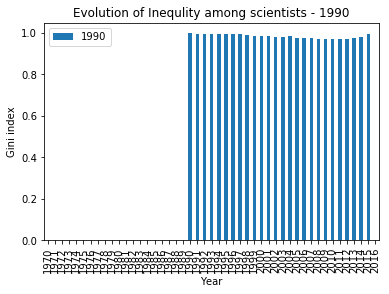

In [13]:
ax = gini_evolution[[1980]].plot(kind='bar', title='Evolution of Inequlity among scientists - 1980')
#ax.plot(non_publishers_track[1990])
ax.set_xlabel("Year")
ax.set_ylabel("Gini index")
plt.show()

ax = gini_evolution[[1990]].plot(kind='bar', title='Evolution of Inequlity among scientists - 1990')
#ax.plot(non_publishers_track[1990])
ax.set_xlabel("Year")
ax.set_ylabel("Gini index")
plt.show()

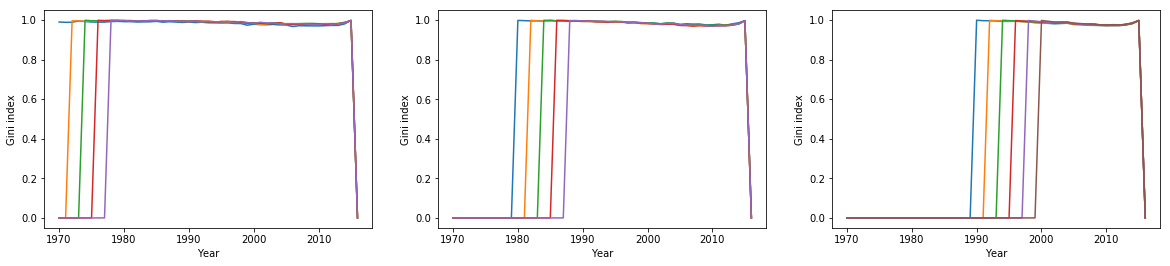

In [14]:
f1 = plt.figure(1,figsize=(20,4))
s1 = f1.add_subplot(131)
ax1 = s1.axes
ax1.set_xlabel("Year")
ax1.set_ylabel("Gini index")
s1.plot(gini_evolution[list(range(1970,1980,2))])
#ax1 = gini_evolution[list(range(1970,1980,2))].plot(title='Evolution of Inequlity among scientists - in 1970s')
#ax.plot(non_publishers_track[1990])

s2 = f1.add_subplot(132)
s2.plot(gini_evolution[list(range(1980,1990,2))])
ax2 = s2.axes
#ax2 = gini_evolution[list(range(1980,1990,2))].plot(title='Evolution of Inequlity among scientists - in 1980s')
#ax.plot(non_publishers_track[1990])
ax2.set_xlabel("Year")
ax2.set_ylabel("Gini index")


s3 = f1.add_subplot(133)
s3.plot(gini_evolution[list(range(1990,2002,2))])
ax3 = s3.axes
#ax2 = gini_evolution[list(range(1980,1990,2))].plot(title='Evolution of Inequlity among scientists - in 1990s')
#ax.plot(non_publishers_track[1990])
ax3.set_xlabel("Year")
ax3.set_ylabel("Gini index")

plt.show()

In [15]:
end_time = timeit.default_timer()
print(end_time)
print('Time taken - ',end_time-start_time)

32.98054660824419
Time taken -  32.980545053241734
